In [113]:
import heapq

import mglearn as mglearn
import np as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import sklearn_evaluation
from sklearn.feature_selection import SelectFromModel, SelectPercentile, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC

!pip install numpy scipy scikit-learn matplotlib pandas
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier
import heapq


You should consider upgrading via the '/Users/engineer/workspace/cse590-machine-learning/venv/bin/python -m pip install --upgrade pip' command.


In [85]:

X = pd.read_csv("../dataset/extracted_features.csv").values
index_for_removal = np.array(
    [
        0, 10, 14, 17, 25, 26, 35, 39, 49, 59, 62,
    ]
)
X_indexed = np.delete(X, index_for_removal, 1)

y = pd.read_csv("../dataset/labels.csv").values
X_train, X_test, y_train, y_test = train_test_split(
    X_indexed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)
y_train = y_train.ravel()

select = SelectPercentile(percentile=90)
select.fit(X_train, y_train)
X_train = select.transform(X_train)
X_test = select.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=200,
    max_features=3,
).fit(X_train, y_train)

select_sfm = SelectFromModel(
    rf,
    threshold='0.1*mean',
)
select_sfm.fit(X_train, y_train)
X_train = select_sfm.transform(X_train)
X_test = select_sfm.transform(X_test)

select_rfe = RFE(
    RandomForestClassifier(
        n_estimators=200, random_state=42
    ), n_features_to_select=40
)

select_rfe.fit(X_train, y_train)
X_train = select_rfe.transform(X_train)
X_test = select_rfe.transform(X_test)

scaler_standard = StandardScaler().fit(X_train)
X_train_standard = scaler_standard.transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

scaler_robust = RobustScaler().fit(X_train)
X_train_robust = scaler_robust.transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

scaler_minmax = MinMaxScaler().fit(X_train)
X_train_minmax = scaler_minmax.transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

pca = PCA(n_components=37, random_state=42)
X_train_pca = pca.fit_transform(X_train_standard)
X_test_pca = pca.transform(X_test_standard)

In [114]:

knn_pipeline = make_pipeline(
    MinMaxScaler(),
    PCA(n_components=37),
    KNeighborsClassifier(
        n_neighbors=9,
    )
)
ksvm_pipeline = make_pipeline(
    MinMaxScaler(),
    SVC(
        kernel='poly',
        C=5,
        degree=1,
        random_state=42
    )
)

logreg = LogisticRegression(C=4.817948717948719)
logreg_pipeline = make_pipeline(
    MinMaxScaler(),
    logreg
)

lsvc = LinearSVC(C=1.6326530612244898)
lsvc_pipeline = make_pipeline(
    MinMaxScaler(),
    lsvc
)

mnb = MultinomialNB(alpha=0.15789473684210525, )
mnb_pipeline = make_pipeline(
    MinMaxScaler(),
    mnb
)

rf = RandomForestClassifier(n_estimators=500, max_features=5, random_state=42)
rf_pipeline = make_pipeline(
    rf
)

gbrt = GradientBoostingClassifier(n_estimators=500, max_depth=1, learning_rate=0.1, random_state=42)
gbrt_pipeline = make_pipeline(
    RobustScaler(),
    gbrt
)

mlp = MLPClassifier(activation='relu', hidden_layer_sizes=256, alpha=0.05, random_state=42)

mlp_pipeline = make_pipeline(
    MinMaxScaler(),
    mlp
)

votingClf = VotingClassifier(
    [
        ('clf1', logreg),
        ('clf2', rf)
    ],
    voting='soft'
)
adaCombo = AdaBoostClassifier(base_estimator=votingClf)
# adaCombo.fit(X_train_pca, y_train)


In [115]:

estimators = [
    # ("ksvm", ksvm_pipeline),
    ('ada', adaCombo),
    ("mlp", mlp_pipeline),
    ("gbrt", gbrt_pipeline),
    # # ("rf", rf_pipeline),
    # # ("mnb", mnb_pipeline),
    # ("knn", knn_pipeline),
    ("lsvc", lsvc_pipeline),
    ("mnb", mnb_pipeline),
    # ("logreg", logreg_pipeline),
]

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=logreg_pipeline
)

In [116]:
import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    stacking_classifier.fit(X_train, y_train)

print(stacking_classifier.score(X_train, y_train))
print(stacking_classifier.score(X_test, y_test))

/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

0.9808450704225352
0.9346846846846847


In [119]:
voting_classifier = VotingClassifier(
    estimators=estimators,
)
voting_classifier.fit(X_train, y_train)
print(voting_classifier.score(X_train, y_train))
print(voting_classifier.score(X_test, y_test))


/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

0.9723943661971831
0.9211711711711712


In [122]:
y_pred = stacking_classifier.predict(X_test)
y_pred_proba = stacking_classifier.predict_proba(X_test)
print(y_pred_proba.shape)
pd.DataFrame({'pred': y_pred, 'proba': y_pred_proba[:, 1]})

(444, 9)


,pred,proba
0,0,0.000001
1,0,0.000056
2,3,0.000417
3,2,0.001206
4,2,0.005576
...,...,...
439,4,0.000118
440,7,0.016132
441,8,0.051948
442,5,0.000075


In [107]:
knn = KNeighborsClassifier(
    n_neighbors=5
)

bag_knn = BaggingClassifier(
    base_estimator=knn,
    n_estimators=2000,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=True,
    random_state=42
).fit(X_train_pca, y_train)

In [108]:
knn.fit(X_test_pca, y_test)
print(knn.score(X_test_pca, y_test))
print(bag_knn.score(X_test_pca, y_test))

/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.8085585585585585
0.8288288288288288


estimators 200 .78
estimators 2000 .80
bootstrap features false .81
bootstrap features true .82
max features .5 0.806
5 neighbors 0.828

In [112]:
lsvc = LinearSVC(
    C=0.4081632653061224
)

bag_lsvc = BaggingClassifier(
    base_estimator=lsvc,
    n_estimators=100,
    max_samples=1.0,
    max_features=0.5,
    bootstrap=True,
    bootstrap_features=True,
    random_state=42
).fit(X_train_pca, y_train)

/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to co

In [111]:
lsvc.fit(X_test_pca, y_test)
print(lsvc.score(X_test_pca, y_test))
print(bag_lsvc.score(X_test_pca, y_test))

0.9459459459459459
0.8400900900900901


/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/engineer/workspace/cse590-machine-learning/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Viewing Images

In [117]:
images = pd.read_csv("../dataset/raw_images.csv").values

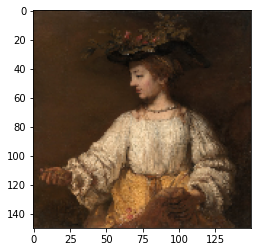

In [118]:
plt.imshow(images[0].reshape(150,150,3))